#### Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

##### Naive Example of NODEs

In [ ]:
import torch
from torch import nn
from torchdiffeq import odeint_adjoint as odeint
# from torchdiffeq import odeint

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
MSE = nn.MSELoss(reduction='none')
SmoothL1 = nn.SmoothL1Loss(reduction='mean', beta=1.0)

class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.linear = nn.Linear(3, 3)
        self.alpha = nn.parameter.Parameter(torch.tensor([1.0, 1.0, 1.0]), requires_grad=True)

    def forward(self, t, y):
        dydt = -self.alpha * y # y' = -alpha * y, y(t) = exp(-alpha * t) * y0
        # dydt = self.linear(y)
        return dydt

class ODEBlock(nn.Module):
    def __init__(self):
        super(ODEBlock, self).__init__()
        self.ode_func = ODEFunc()

    def forward(self, y0, t):
        # y0: (1, input_dim)
        # t: (n_points,)
        y_pred = odeint(self.ode_func, y0, t, method='dopri5')
        return y_pred
    
    @torch.no_grad()
    def evaluate(self, y0, t_eval):
        # y0: (1, input_dim)
        # t_eval: (n_points,)
        y_eval = self.forward(y0, t_eval)
        return y_eval[-1]

def train_model(model, optimizer, y0, y_observed, t_observed, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        y_pred = model(y0, t_observed)
        loss = SmoothL1(y_pred, y_observed)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

def eval_model(model, y0, t_eval):
    model.eval()
    y_pred = model.evaluate(y0, t_eval)
    print(f"y_pred={y_pred.detach().cpu().numpy()}")

device = torch.device("cuda:3")
model = ODEBlock().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000

y0 = torch.tensor([1.0, 2.0, 3.0]).to(device)
y_observed = torch.tensor([[1.0, 2.0, 3.0], [2.0, 4.0, 6.0], [3.0, 8.0, 15.0]]).to(device)
t_observed = torch.tensor([3.0, 10.0, 17.0]).to(device)

train_model(model, optimizer, y0, y_observed, t_observed, num_epochs)
eval_model(model, y0, torch.tensor([3.0, 17.0]).to(device))
eval_model(model, y0, torch.tensor([3.0, 10.0]).to(device))
eval_model(model, y0, torch.tensor([3.0, 5.0]).to(device))

Epoch 0, Loss: 3.8883
Epoch 100, Loss: 0.0616
Epoch 200, Loss: 0.0302
Epoch 300, Loss: 0.0302
Epoch 400, Loss: 0.0302
Epoch 500, Loss: 0.0302
Epoch 600, Loss: 0.0302
Epoch 700, Loss: 0.0302
Epoch 800, Loss: 0.0302
Epoch 900, Loss: 0.0302
y_pred=[ 3.0706701  8.        14.848471 ]
y_pred=[1.1738279 2.4380276 3.7700245]


In [ ]:
model.ode_func.alpha

Parameter containing:
tensor([-0.0801, -0.0990, -0.1142], device='cuda:3', requires_grad=True)

In [ ]:
torch.exp(-model.ode_func.alpha * 2) * y0

tensor([1.1738, 2.4380, 3.7700], device='cuda:3', grad_fn=<MulBackward0>)

#### PAGA Topology (Population Adjacency Matrix)

In [10]:
paga = pd.read_csv('./data/graph_table.csv', index_col=0).astype(np.int32)
paga

,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11
c1,0,1,0,0,0,0,0,1,0,0,0
c2,0,0,1,1,1,0,0,0,0,0,0
c3,0,0,0,0,0,0,0,0,0,0,0
c4,0,0,0,0,0,0,0,0,0,0,0
c5,0,0,0,0,0,1,0,0,0,0,0
c6,0,0,0,0,0,0,1,0,0,0,0
c7,0,0,0,0,0,0,0,0,0,0,0
c8,0,0,0,0,0,0,0,0,1,1,1
c9,0,0,0,0,0,0,0,0,0,0,0
c10,0,0,0,0,0,0,0,0,0,0,1


In [11]:
paga.shape

(11, 11)

#### # of cells (per timepoints, per meta-clone, per population)

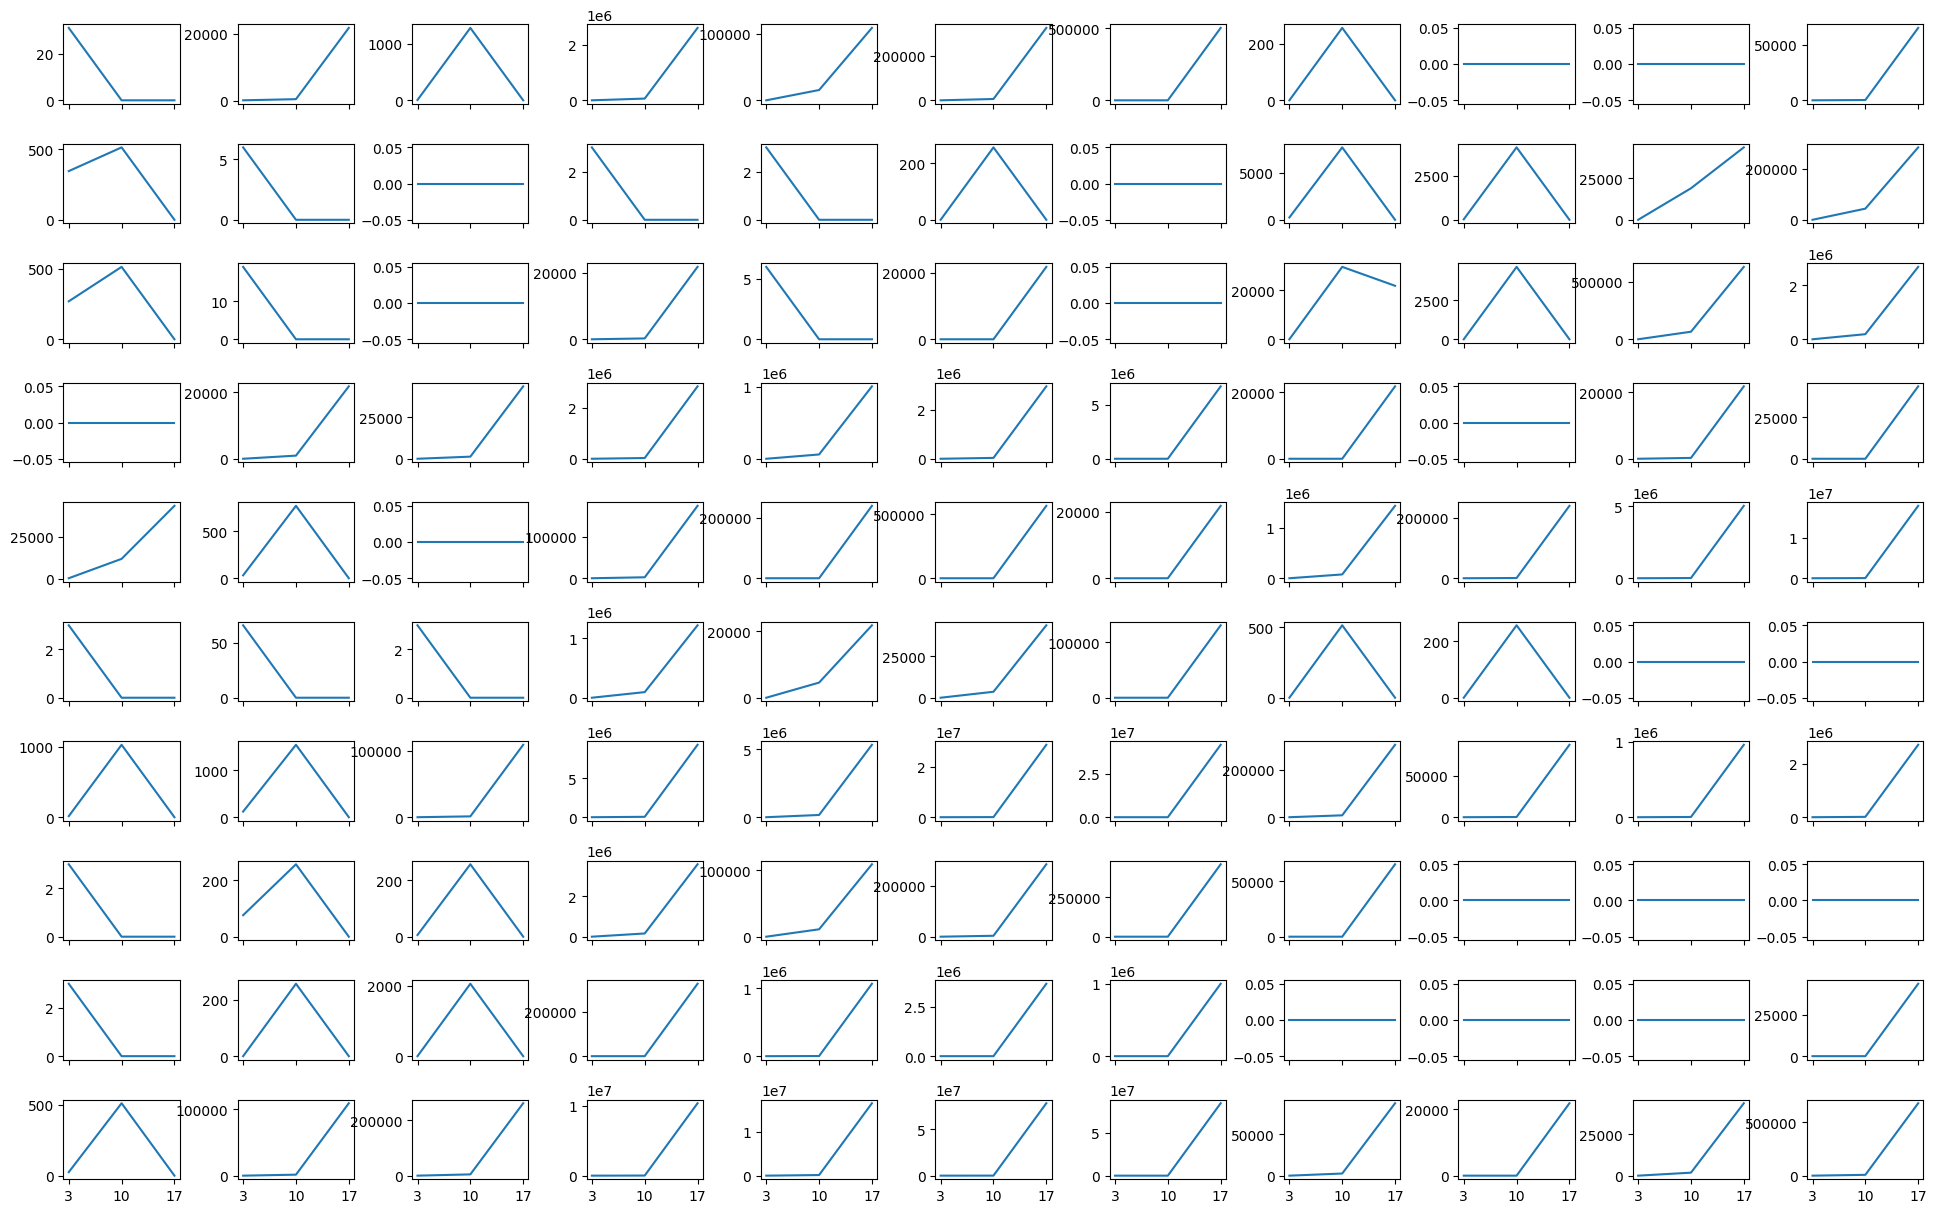

In [3]:
array = np.loadtxt("./data/kinetics_array_correction_factor.txt")
array_ori = array.reshape(array.shape[0], array.shape[1] // 11, 11)

fig, ax = plt.subplots(10, 11, figsize=(24, 15), sharex=True)

for i in range(10):
    for j in range(11):
        ax[i][j].plot([3, 10, 17], array_ori[i, :, j])
        ax[i][j].set_xticks([3, 10, 17]) 

fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.5)

In [4]:
array_ori = torch.swapaxes(torch.tensor(array_ori), 0, 1)
array_ori.shape

torch.Size([3, 10, 11])

#### Generate Background Cells

In [61]:
background = torch.sum(array_ori, axis=1).unsqueeze(1)
background.shape

torch.Size([3, 1, 11])

In [72]:
array_ori = torch.concatenate((array_ori, background), axis=1)
array_ori.shape

torch.Size([3, 11, 11])

#### Test

In [3]:
device = torch.device("cuda:3")
t_observed = torch.tensor([3.0, 10.0, 17.0]).to(device)

from clonaltrans import clonaltrans, utils, config
paga, array_total = utils.get_topo_obs(data_dir='./data', device=device)
print (array_total.mean())

model = clonaltrans.CloneTranModel(N=array_total, L=paga, config=config.Configuration()).to(device=device)
model.train_model(t_observed)

Topology graph loaded.
Input cell data (num_timepoints, num_clones, num_populations) loaded.
Background reference cells generated.
tensor(302.0528, device='cuda:3')


Delta 0.212, BaseK 0.000, Observation 98.360: 100%|██████████| 400/400 [33:38<00:00,  5.05s/it]  


There are 2 observed timepoints except the inital time.


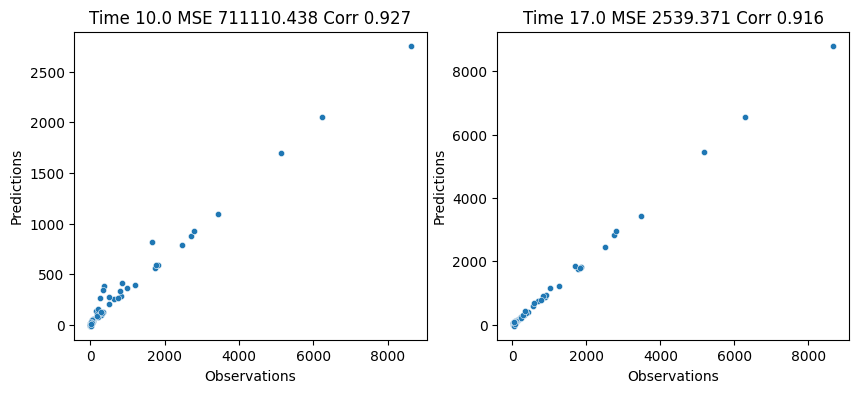

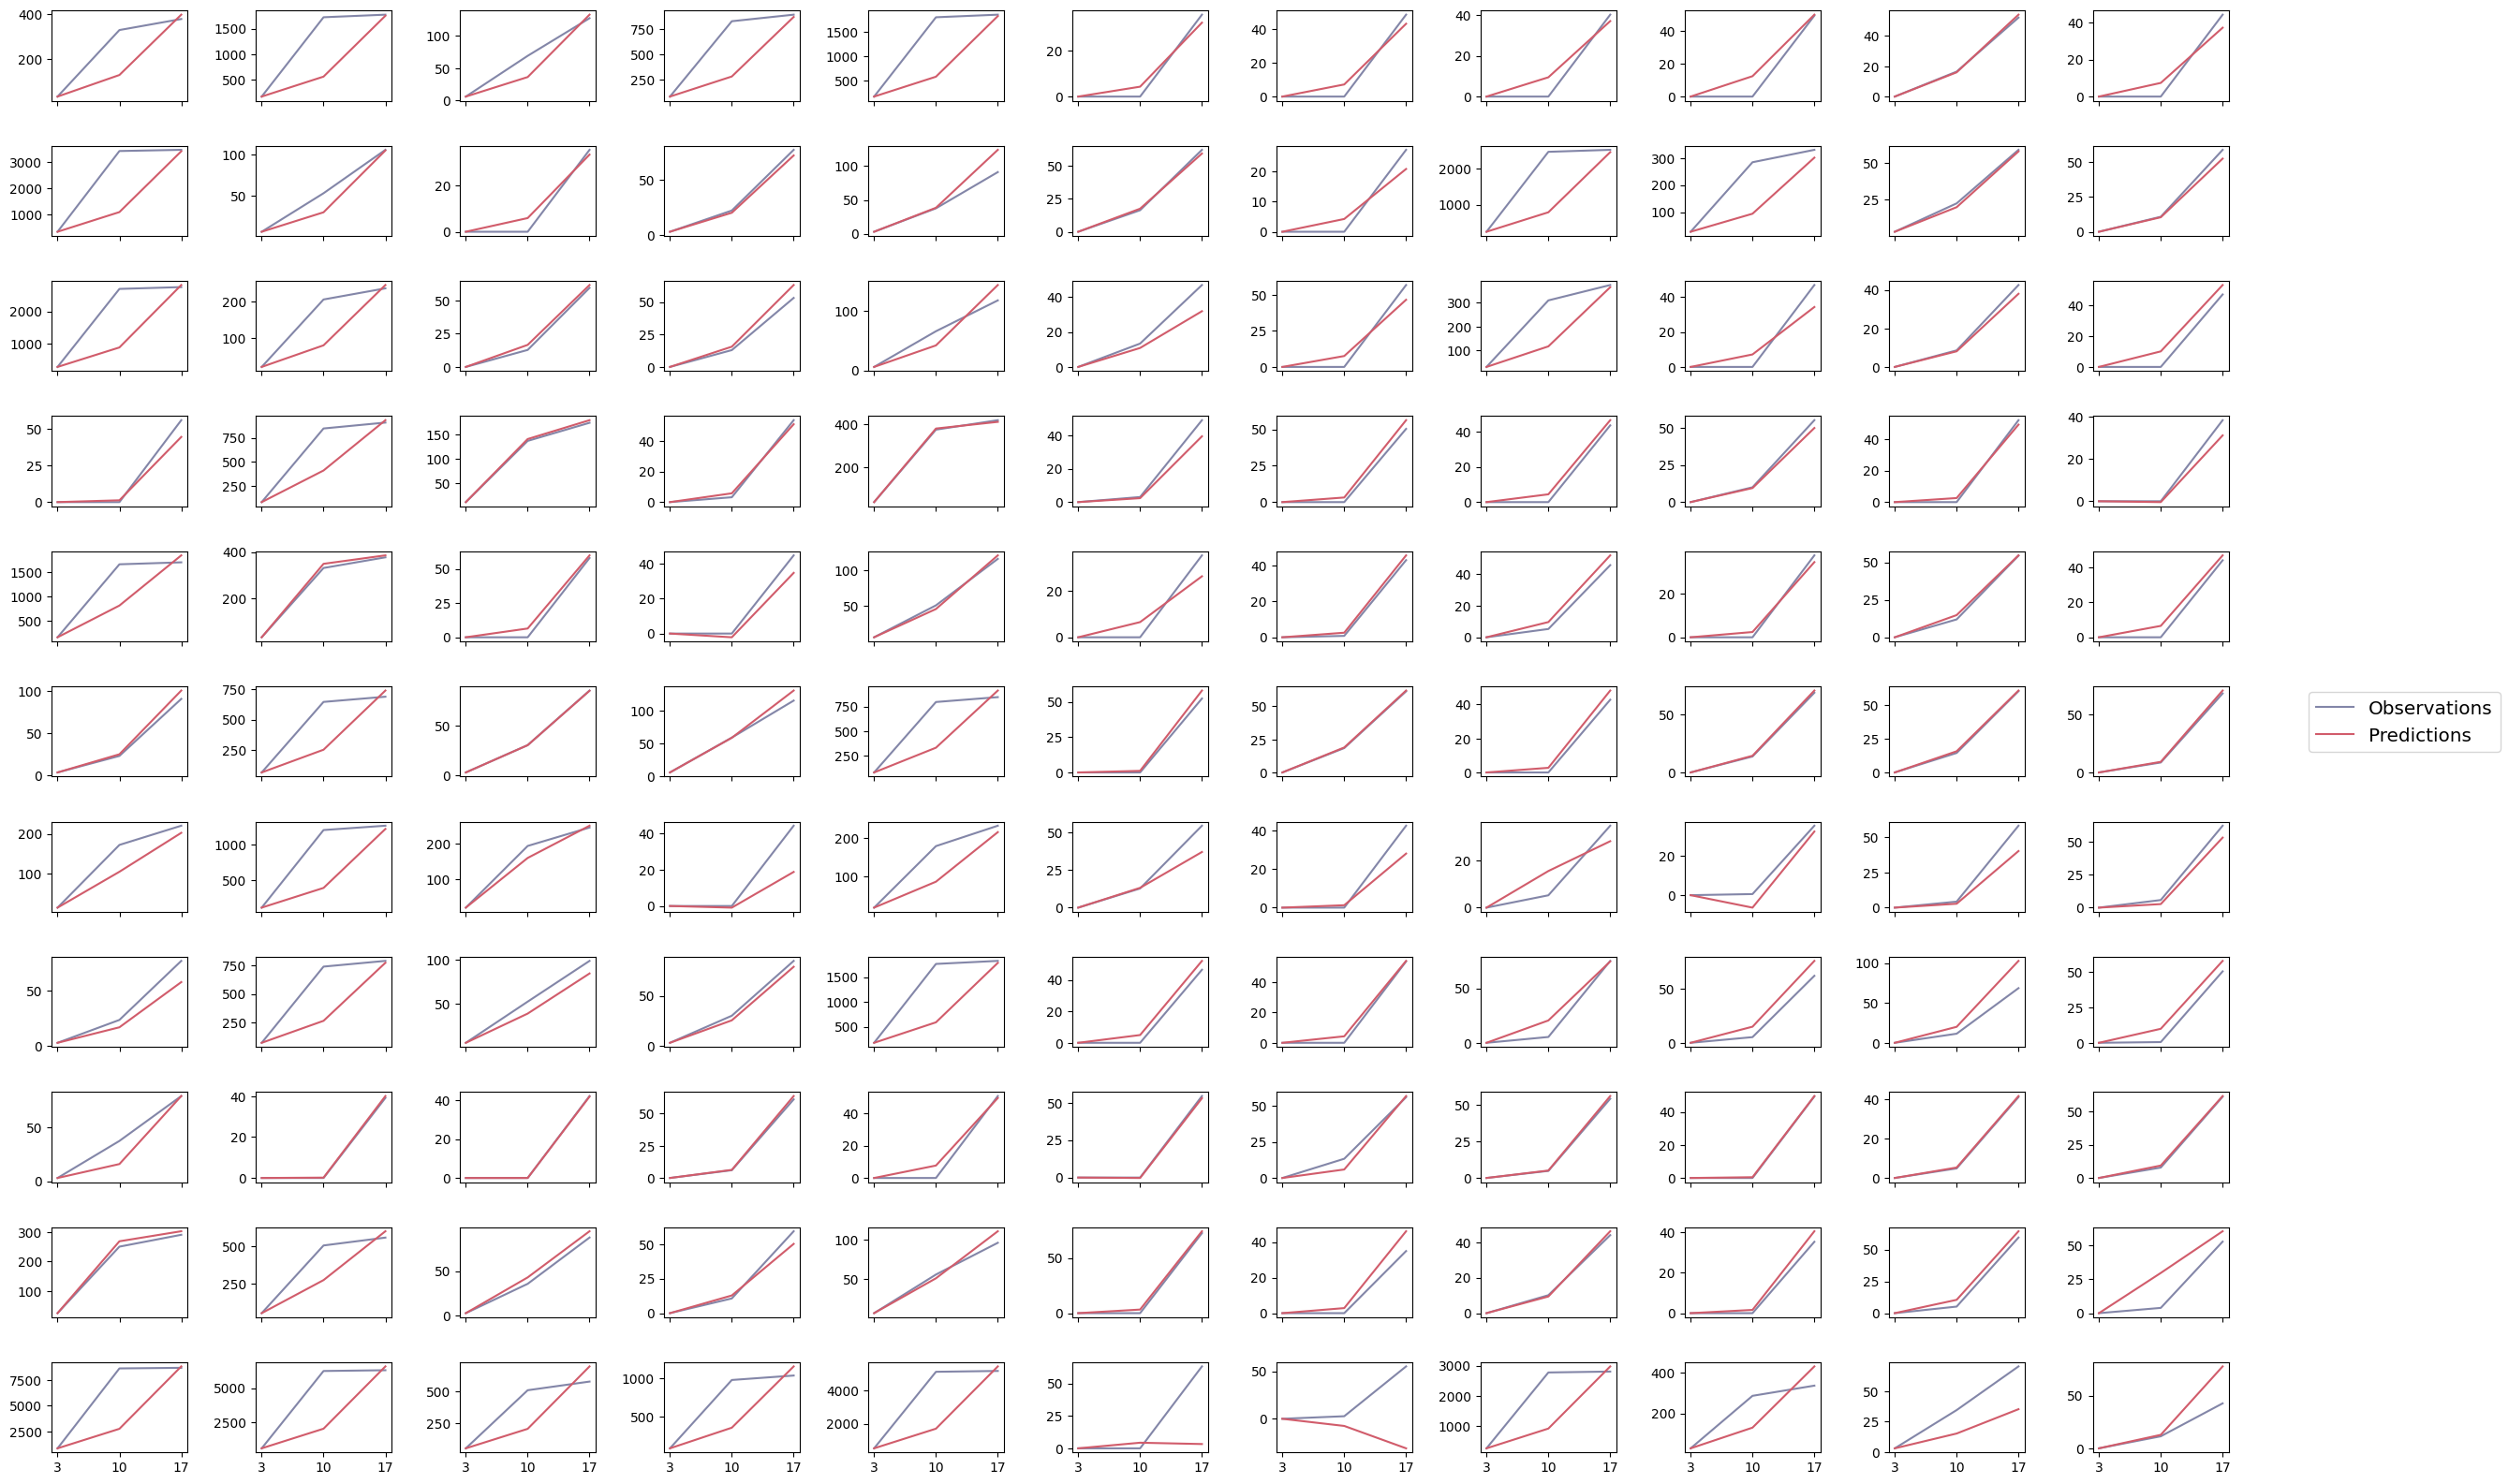

In [4]:
from clonaltrans import pl
pl.eval_predictions(model, t_observed)

In [13]:
np.round(model.matrix_K[-1].detach().cpu().numpy(), 3)

array([[ 0.001,  0.002,  0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.003,
         0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.001,  0.   ,  0.001,  0.   ,  0.   ,  0.   ,
        -0.   ,  0.   ,  0.   ],
       [-0.   , -0.   , -0.   , -0.   ,  0.   ,  0.   , -0.   , -0.   ,
        -0.   ,  0.   ,  0.   ],
       [ 0.   , -0.   ,  0.   ,  0.   , -0.   ,  0.   , -0.   , -0.   ,
        -0.   , -0.   ,  0.   ],
       [ 0.   , -0.   ,  0.   ,  0.   ,  0.002, -0.001,  0.   ,  0.   ,
        -0.   ,  0.   ,  0.   ],
       [ 0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.001, -0.   , -0.   ,
        -0.   , -0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , -0.   , -0.   ,  0.   , -0.002,  0.   ,
         0.   , -0.   ,  0.   ],
       [-0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   ,  0.001,
        -0.   ,  0.003,  0.001],
       [-0.   ,  0.   , -0.   ,  0.   , -0.   , -0.   ,  0.   ,  0.   ,
         0.002,  0.   , -0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   , -0.   ,

In [14]:
(np.round(model.matrix_K[-1].detach().cpu().numpy(), 3) != 0).sum()

15

In [15]:
paga.sum()

tensor(22., device='cuda:3')

In [16]:
np.round((model.matrix_K[0]).detach().cpu().numpy(), 3)

array([[-0.007,  0.001,  0.002, -0.002, -0.001,  0.001,  0.006,  0.002,
         0.001, -0.004, -0.002],
       [ 0.001, -0.001,  0.002, -0.01 , -0.001,  0.016, -0.   , -0.035,
         0.002,  0.002, -0.001],
       [ 0.004,  0.001, -0.001,  0.002, -0.015,  0.002, -0.05 ,  0.001,
         0.006,  0.01 ,  0.091],
       [-0.063,  0.09 ,  0.003,  0.001,  0.009,  0.003,  0.086, -0.001,
        -0.003, -0.001, -0.009],
       [-0.008,  0.058, -0.001,  0.003,  0.088,  0.011,  0.064, -0.01 ,
         0.104,  0.004, -0.008],
       [ 0.001,  0.044, -0.005, -0.001, -0.001, -0.003,  0.019, -0.   ,
         0.113,  0.003,  0.001],
       [ 0.003,  0.009,  0.   , -0.006, -0.001,  0.011, -0.   , -0.002,
         0.01 ,  0.002, -0.013],
       [-0.001,  0.001, -0.008, -0.001,  0.001, -0.002, -0.002, -0.002,
         0.002, -0.001,  0.042],
       [ 0.   , -0.001,  0.   , -0.   ,  0.001, -0.001,  0.001,  0.001,
        -0.   , -0.003,  0.001],
       [-0.021,  0.017, -0.001,  0.004, -0.   ,  0.001,